In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MathsUtilities as MUte
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.dates as mdates
import CAMP as camp
import copy
import json
%matplotlib inline

In [2]:
Envs = ['WL', 'CL', 'WS', 'CS']

In [3]:
EnvsExptNames = ['LN','LV','SN','SV']

In [4]:
EnvsNameConvert = pd.Series(index=EnvsExptNames,data=Envs)

In [5]:
def convertVernTreatnames(N):
    if N == 'V':
        return 'C'
    if N == 'N':
        return 'W'

In [6]:
EnvsNameConvert

LN    WL
LV    CL
SN    WS
SV    CS
dtype: object

In [7]:
SowDates = pd.Series(index = Envs,data = ['2018-11-03','2018-11-03','2018-07-06','2018-08-04'])
SowDates

WL    2018-11-03
CL    2018-11-03
WS    2018-07-06
CS    2018-08-04
dtype: object

In [8]:
TransitionDates =  pd.Series(index = Envs,data = ['2018-11-04','2019-01-04','2018-07-07','2018-09-28'])
TransitionDates

WL    2018-11-04
CL    2019-01-04
WS    2018-07-07
CS    2018-09-28
dtype: object

## Bring in trial design data frame

In [9]:
Design = pd.read_excel('./RawData/NPI_Agribio2018/expdb_AgriBio2018.xlsx',sheet_name='Design',engine='openpyxl')
Design.set_index('Plot',inplace=True)

## Bring in MetData to calculate thermal time

In [10]:
#Bring in the APSIM met files
WLmet = pd.read_csv('./RawData/NPI_Agribio2018/LN.met',sep='\t',skiprows=11)
WLmet.drop(0,inplace=True)
for c in WLmet.columns:
    WLmet.loc[:,c] = pd.to_numeric(WLmet.loc[:,c])
WLmet.loc[:,'date'] = [dt.datetime(WLmet.loc[x,'year'],1,1) + dt.timedelta(float(WLmet.loc[x,'day'])) for x in WLmet.index]
WLmet.set_index('date',inplace=True)
WLmet.drop(['year','day'],axis=1,inplace=True)
WLmet.loc[SowDates['WL']:,'AccumTtSow'] = WLmet.loc[SowDates['WL']:,'mint'].cumsum()

WSmet = pd.read_csv('./RawData/NPI_Agribio2018/SN.met',sep='\t',skiprows=11)
WSmet.drop(0,inplace=True)
for c in WSmet.columns:
    WSmet.loc[:,c] = pd.to_numeric(WSmet.loc[:,c])
WSmet.loc[:,'date'] = [dt.datetime(WSmet.loc[x,'year'],1,1) + dt.timedelta(float(WSmet.loc[x,'day'])) for x in WSmet.index]
WSmet.set_index('date',inplace=True)
WSmet.drop(['year','day'],axis=1,inplace=True)
WSmet.loc[SowDates['WS']:,'AccumTtSow'] = WSmet.loc[SowDates['WS']:,'mint'].cumsum()


CLmet = pd.read_csv('./RawData/NPI_Agribio2018/LV.met',sep='\t',skiprows=11)
CLmet.drop(0,inplace=True)
for c in CLmet.columns:
    CLmet.loc[:,c] = pd.to_numeric(CLmet.loc[:,c])
CLmet.loc[:,'date'] = [dt.datetime(CLmet.loc[x,'year'],1,1) + dt.timedelta(float(CLmet.loc[x,'day'])) for x in CLmet.index]
CLmet.set_index('date',inplace=True)
CLmet.drop(['year','day'],axis=1,inplace=True)
CLmet.loc[SowDates['CL']:,'AccumTtSow'] = CLmet.loc[SowDates['CL']:,'mint'].cumsum()

CSmet = pd.read_csv('./RawData/NPI_Agribio2018/SV.met',sep='\t',skiprows=11)
CSmet.drop(0,inplace=True)
for c in CSmet.columns:
    CSmet.loc[:,c] = pd.to_numeric(CSmet.loc[:,c])
CSmet.loc[:,'date'] = [dt.datetime(CSmet.loc[x,'year'],1,1) + dt.timedelta(float(CSmet.loc[x,'day'])) for x in CSmet.index]
CSmet.set_index('date',inplace=True)
CSmet.drop(['year','day'],axis=1,inplace=True)
CSmet.loc[SowDates['CS']:,'AccumTtSow'] = CSmet.loc[SowDates['CS']:,'mint'].cumsum()

Met = pd.concat([WSmet,WLmet,CSmet,CLmet],keys=['WS','WL','CS','CL'])

#Bring in the datalogger data from in the growth rooms
Temp = pd.read_excel('./RawData/NPI_Agribio2018/GrowthRoomTemp.xlsx',engine='openpyxl')
Temp.Date = pd.to_datetime(Temp.Date)
Temp.Environment = [EnvsNameConvert[Temp.loc[x,'Environment']] for x in Temp.index]
Temp.set_index(['Environment','Date'],inplace=True)
CanopyTemp = pd.read_excel('./RawData/NPI_Agribio2018/GrowthRoomsCanopyTemp.xlsx',header=2,engine='openpyxl')
CanopyTemp.Date = pd.to_datetime(CanopyTemp.Date)
CanopyTemp.Environment = [EnvsNameConvert[CanopyTemp.loc[x,'Environment']] for x in CanopyTemp.index]
CanopyTemp.set_index(['Environment','Date'],inplace=True)

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_3244\4092426564.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  WLmet.loc[:,c] = pd.to_numeric(WLmet.loc[:,c])
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_3244\4092426564.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  WSmet.loc[:,c] = pd.to_numeric(WSmet.loc[:,c])
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_3244\4092426564.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain th

## Graph up met data to check it looks right

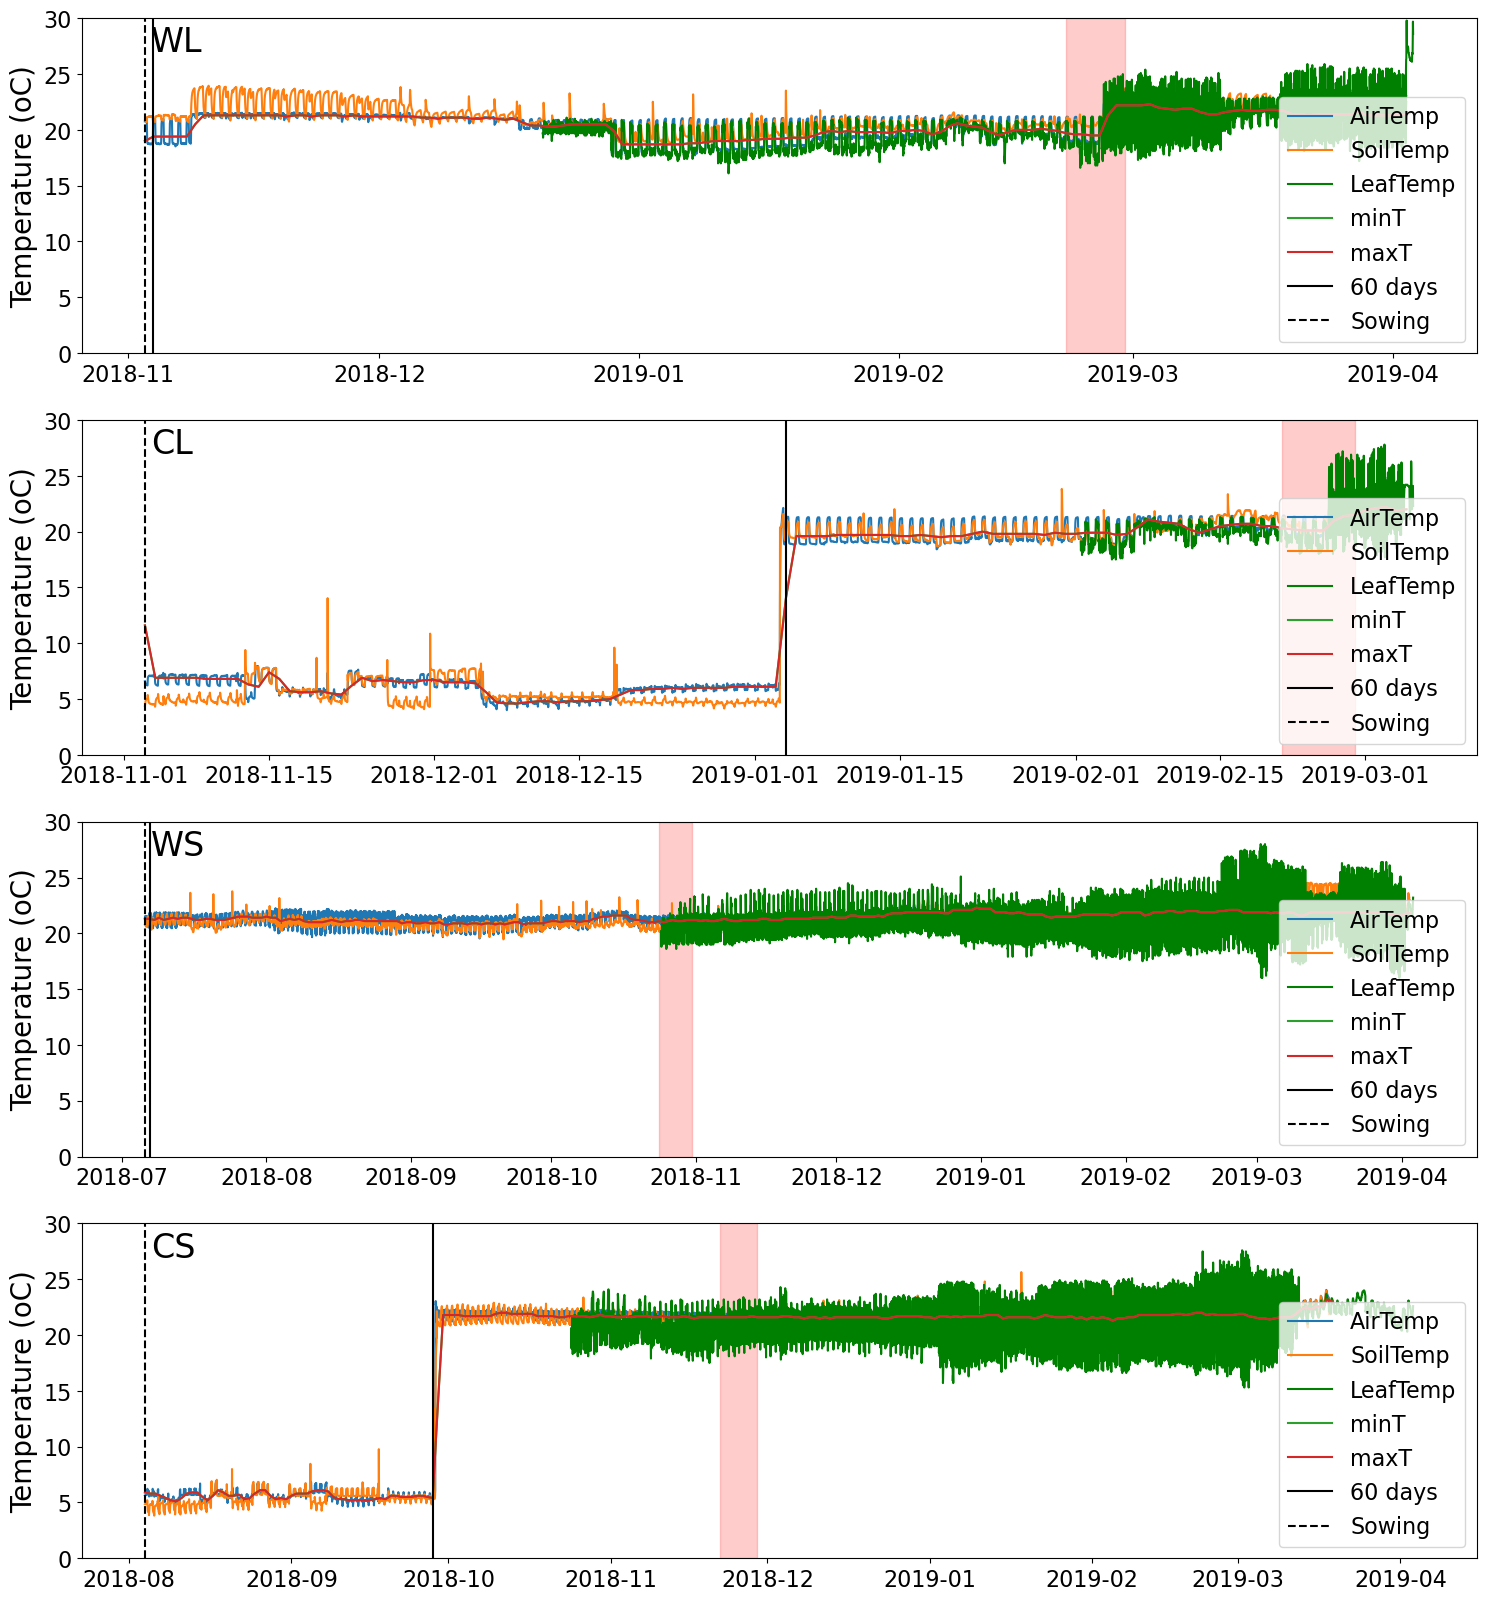

In [11]:
Graph = plt.figure(figsize=(18,20))
pos=1
for e in Envs:
    ax = Graph.add_subplot(4,1,pos)
    SowDate = pd.to_datetime(SowDates[e])
    ChangeDate = pd.to_datetime(TransitionDates[e])
    StartSlice = SowDate + dt.timedelta(110)
    EndSlice = StartSlice + dt.timedelta(7)
    plt.plot(Temp.loc[e,'AirTemp'].loc[SowDate:],label='AirTemp')
    plt.plot(Temp.loc[e,'SoilTemp'].loc[SowDate:],label='SoilTemp')
    plt.plot(CanopyTemp.loc[e,'LeafTemp'].loc[SowDate:],color='g',label='LeafTemp')
    plt.plot(Met.loc[e,'mint'].loc[SowDate:],label='minT')
    plt.plot(Met.loc[e,'mint'].loc[SowDate:],label='maxT')
    plt.plot([ChangeDate]*2,[0,30],color='k',label='60 days')
    plt.plot([SowDate]*2,[0,30],'--',color='k',label='Sowing')
    ax.axvspan(StartSlice,EndSlice,alpha=0.2,color='r')
    plt.text(0.05,0.9,e,transform = ax.transAxes,fontsize=24)
    plt.ylim(0,30)
    plt.legend(loc=4,fontsize=16)
    plt.ylabel('Temperature (oC)',fontsize=20)
    plt.tick_params(labelsize=16)
    pos+=1
Graph.patch.set_facecolor('white')

### The pink shaded period is expanded in the plot below

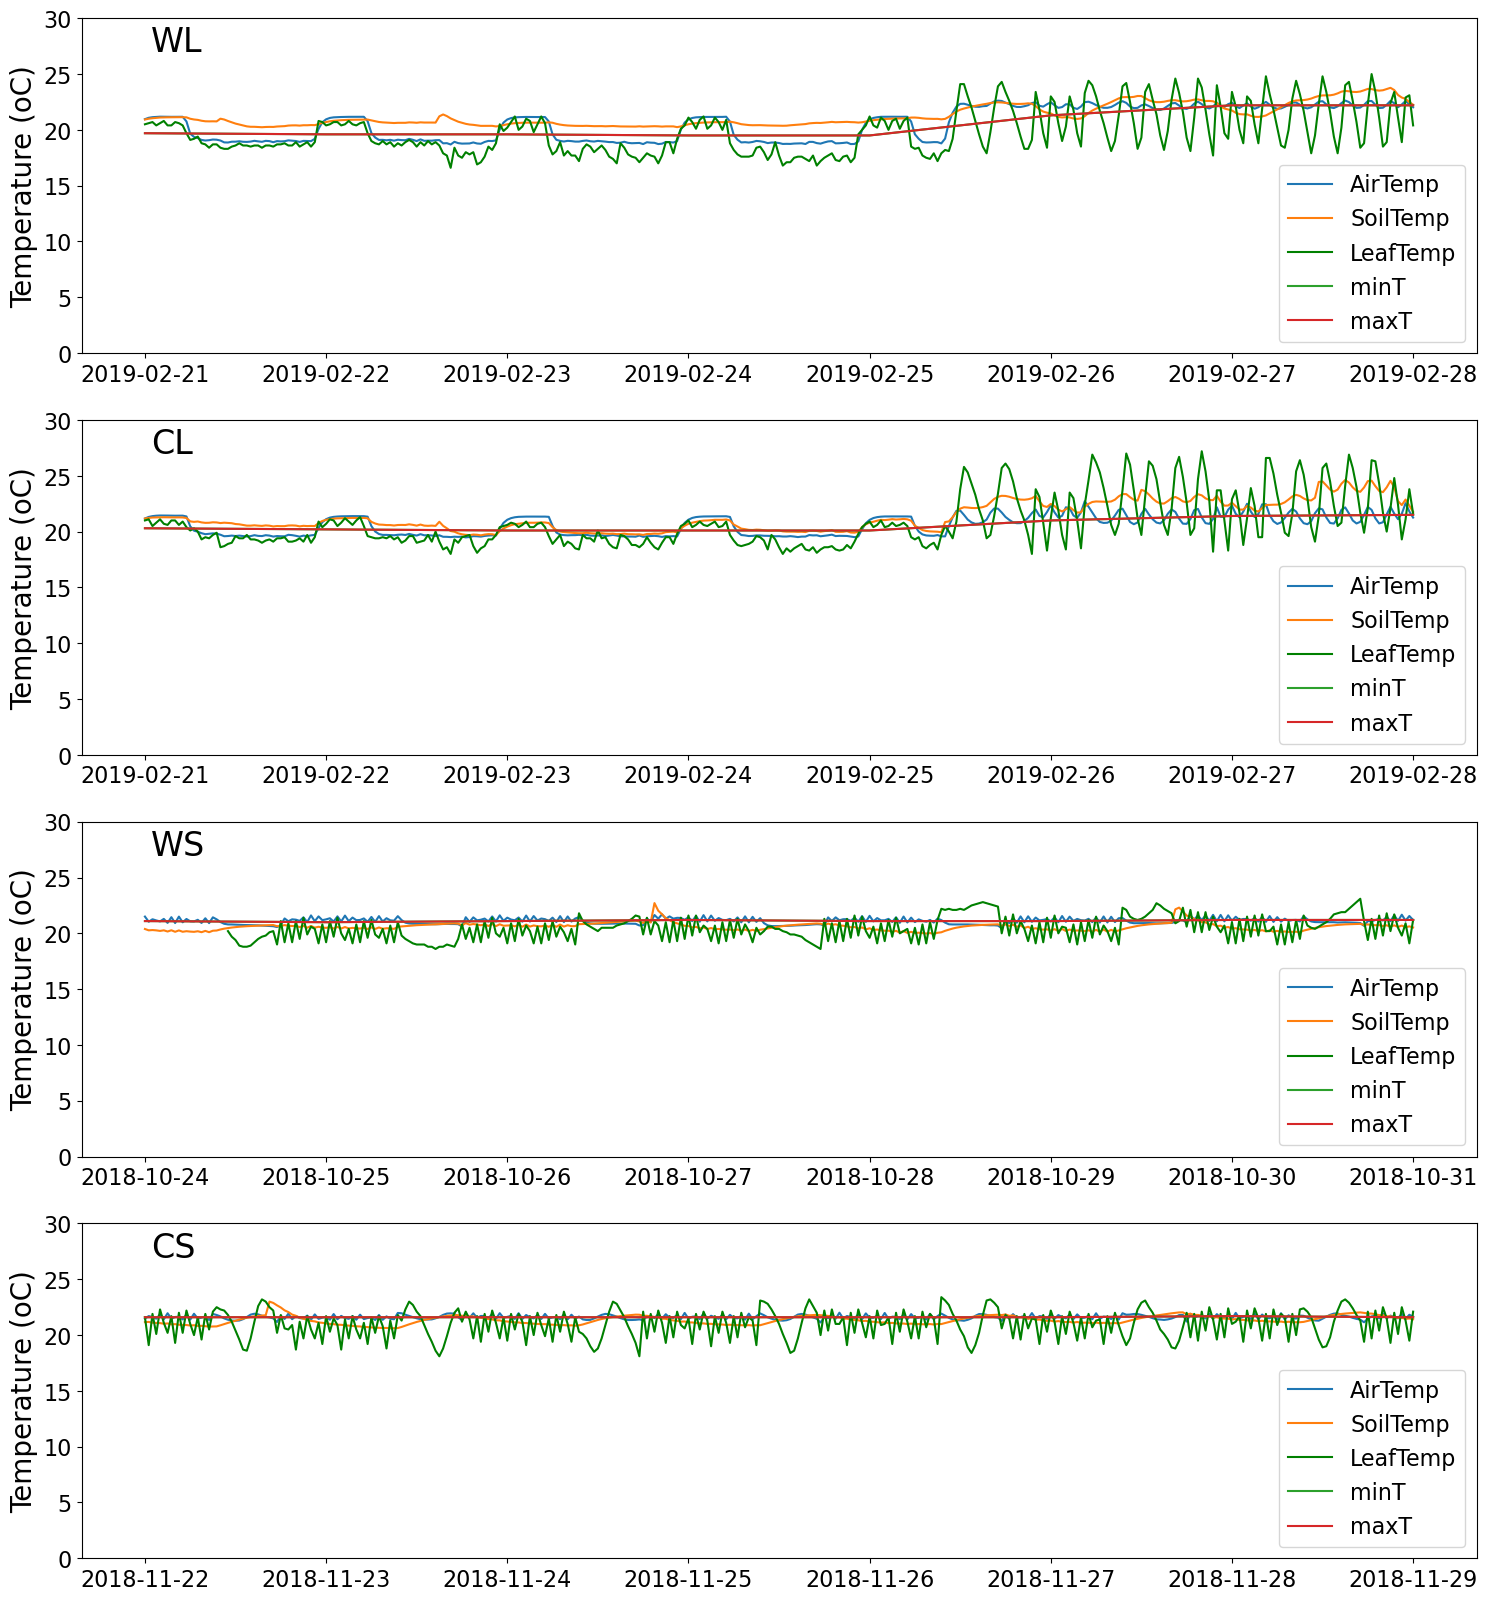

In [12]:
Graph = plt.figure(figsize=(18,20))
pos=1
for e in Envs:
    ax = Graph.add_subplot(4,1,pos)
    SowDate = pd.to_datetime(SowDates[e])
    ChangeDate = SowDate + dt.timedelta(60)
    StartSlice = SowDate + dt.timedelta(110)
    EndSlice = StartSlice + dt.timedelta(7)
    plt.plot(Temp.loc[e,'AirTemp'].loc[StartSlice:EndSlice],label='AirTemp')
    plt.plot(Temp.loc[e,'SoilTemp'].loc[StartSlice:EndSlice],label='SoilTemp')
    plt.plot(CanopyTemp.loc[e,'LeafTemp'].loc[StartSlice:EndSlice],color='g',label='LeafTemp')
    plt.plot(Met.loc[e,'mint'].loc[StartSlice:EndSlice],label='minT')
    plt.plot(Met.loc[e,'mint'].loc[StartSlice:EndSlice],label='maxT')
    plt.text(0.05,0.9,e,transform = ax.transAxes,fontsize=24)
    plt.ylim(0,30)
    plt.legend(loc=4,fontsize=16)
    plt.ylabel('Temperature (oC)',fontsize=20)
    plt.tick_params(labelsize=16)
    pos+=1
Graph.patch.set_facecolor('white')

## Points to note
- Duration of vernalisation treatment was less for the SV treatment
- Air, soil and leaf tempertures appear close together and the temperaures we have in the APSIM file do a reasonable job of approximating this.

## Next lets bring in the FLN data

In [13]:
FLNData = pd.read_excel('./RawData/NPI_Agribio2018/expdb_AgriBio2018.xlsx',sheet_name='Phenotype_FLN',engine='openpyxl')
FLNData.loc[:,'Photoperiod'] = [Design.loc[x,'TrialCode'].split('-')[1][0] for x in FLNData.loc[:,'Plot']]
FLNData.loc[:,'VegPhaseTemp'] = [Design.loc[x,'TrialCode'].split('-')[1][1] for x in FLNData.loc[:,'Plot']]
FLNData.loc[:,'VegPhaseTemp'] = [convertVernTreatnames(FLNData.loc[x,'VegPhaseTemp']) for x in FLNData.index]
FLNData.loc[:,'Genotype'] = [Design.loc[x,'Genotype'] for x in FLNData.loc[:,'Plot']]
FLNData.set_index(['Photoperiod','VegPhaseTemp','Genotype'],inplace=True)
FLNData.sort_index(axis=0,inplace=True)
Cultivars = FLNData.index.get_level_values(2).drop_duplicates()

In [14]:
def MakeGenotypeBarPlot(Geno,Axis):
    width = 0.4
    ind = np.arange(4) + width
    colors = ['b','b','r','r']
    fills = ['b','w','w','r']
    SubPos = 0
    for Photo,VegT in [('L','C'),('S','C'),('S','W'),('L','W')]:
            try:
                y = FLNData.loc[(Photo,VegT,Geno),'Value']
            except:
                y = []
            try:
                x = np.add(list(range(len(y))),SubPos)
            except:
                x = []
            plt.plot(x,y, 'o', markersize = 12, mec = colors[SubPos],
                     mfc=fills[SubPos], label = Photo + " " + VegT)
            try:
                plt.bar(SubPos,y.median(),0.8,
                        edgecolor=colors[SubPos], color = fills[SubPos],
                        linewidth=3,alpha=0.4)
            except:
                dummy = 'bla bla'
            #plt.xticks([3,9,15,21])
            plt.text(1,24,Geno, fontsize=16);
            plt.ylim(0,28)
            SubPos +=1
    Axis.spines['right'].set_visible(False)
    Axis.spines['top'].set_visible(False)
    plt.tick_params(axis='x',direction='in',labelsize = 12,rotation=30)
    try:
        CL = FLNData.loc[('L','C',cul),'Value'].median()
        CS = FLNData.loc[('S','C',cul),'Value'].median()
        WS = FLNData.loc[('S','W',cul),'Value'].median() 
        WL = FLNData.loc[('L','W',cul),'Value'].median()
        PlotLNlines(CL,CS,WS,WL,8)
        #plt.plot([18,24],[MinLN + VrnLN]*2,'-',color='k',lw=2)
        #plt.text(21,22,str(VxPLN))
    except:
        do = 'nothing'    
    
    if Pos in list(range(1,101,5)):
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True)
        plt.ylabel('FinalLeafNumber',fontsize=16)
    else:
        plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=False)

In [15]:
#Bolac -  No PvLN
#Wylcatchum - negative
#Sunlanm - positive
#Axe - little response
FLNegs = pd.DataFrame(columns = ['CL','WL','CS','WS'])
for c in ['AXE','BOLAC','SUNLAMB','WYALKATCHEM']:
    FLNegs.loc[c,:] = FLNData.loc[(slice(None),slice(None),c),'Value'].groupby(['Photoperiod','VegPhaseTemp']).mean().values
#FLNegs.to_pickle('FLNegs.pkl')

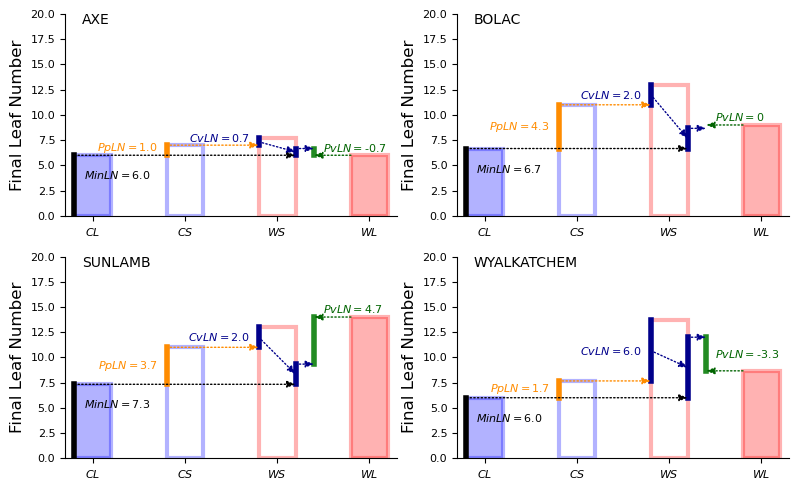

In [16]:
Fig = plt.figure(figsize=(8, 5))
pos=1
for c in FLNegs.index:
    WL = FLNegs.loc[c,'WL']
    CL = FLNegs.loc[c,'CL']
    WS = FLNegs.loc[c,'WS']
    CS = FLNegs.loc[c,'CS']
    Axis = Fig.add_subplot(2,2,pos)
    camp.plotFLNs(CL, CS, WS, WL,Axis,8,20)
    camp.plotLNlines(CL, CS, WS, WL,8)
    plt.text(0.05,0.95,c,transform=Axis.transAxes)
    pos+=1
    
plt.tight_layout()
#Fig.savefig('C:\\Users\\cflhxb\\Dropbox\\WheatFlowering\\Fig1.jpg',format='jpg',dpi=300,bbox_inches="tight")     
Fig.patch.set_facecolor('white')

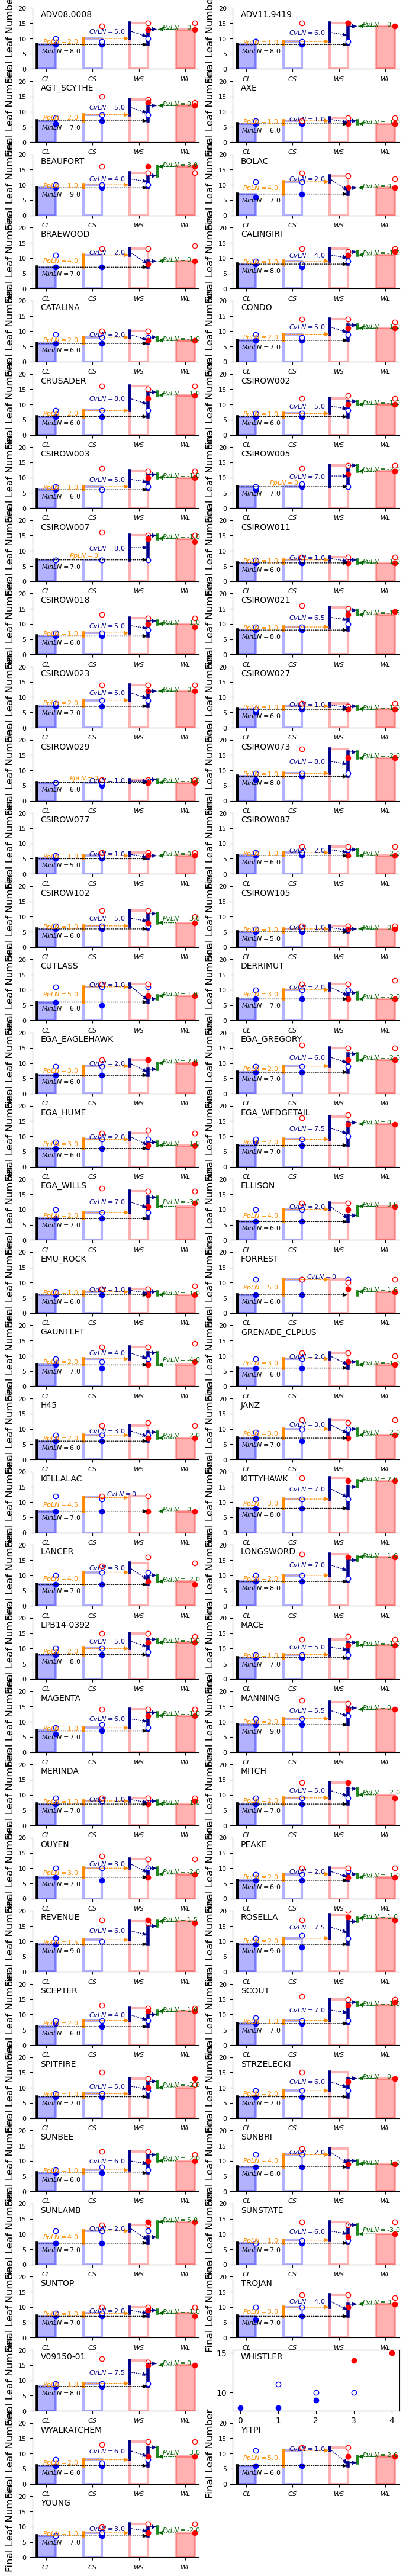

In [17]:
Fig = plt.figure(figsize=(8, 80))
Pos = 1
for cul in Cultivars:
    Axis = Fig.add_subplot(50,2,Pos)
    try:
        CL = FLNData.loc[('L','C',cul),'Value'].median()
        CS = FLNData.loc[('S','C',cul),'Value'].median()
        WS = FLNData.loc[('S','W',cul),'Value'].median() 
        WL = FLNData.loc[('L','W',cul),'Value'].median()
        camp.plotFLNs(CL,CS,WS,WL,Axis,8,20)
        camp.plotLNlines(CL,CS,WS,WL,8)
    except:
        do = 'nothing'
        
    colors = ['b','b','r','r']
    fills = ['b','w','w','r']
    SubPos = 0
    for Photo,VegT in [('L','C'),('S','C'),('S','W'),('L','W')]:
            try:
                y = FLNData.loc[(Photo,VegT,cul),'Value']
            except:
                y = []
            try:
                x = np.add(list(range(len(y))),SubPos)
            except:
                x = []
            plt.plot(x,y, 'o', markersize = 6, mec = colors[SubPos],
                     mfc=fills[SubPos], label = Photo + " " + VegT)
            SubPos +=1
    plt.text(0.05,0.85,cul,transform=Axis.transAxes)
    Pos += 1
Fig.patch.set_facecolor('white')

In [18]:
GenoParams = pd.DataFrame(index = Cultivars)
FLN = FLNData.groupby(['Photoperiod','VegPhaseTemp','Genotype']).mean()
GenoParams.loc[:,'MinLeafNumber'] = FLN.loc[('L','C'),'Value']
GenoParams.loc[:,'FLNPPSens'] = FLN.loc[('S','C'),'Value'] - FLN.loc[('L','C'),'Value']
GenoParams.loc[:,'FLNVnSens'] = FLN.loc[('L','W'),'Value'] - FLN.loc[('L','C'),'Value']
GenoParams.loc[:,'FLN_CL'] = FLN.loc[('L','C'),'Value']
GenoParams.loc[:,'FLN_WL'] = FLN.loc[('L','W'),'Value']
GenoParams.loc[:,'FLN_CS'] = FLN.loc[('S','C'),'Value']
GenoParams.loc[:,'FLN_WS'] = FLN.loc[('S','W'),'Value']
FLN.loc[:,'HSTS'] = (FLN.loc[:,'Value'] - 2.8)/1.1
def VITS_geno(ind):
    if ind[0] == 'S':
        PPS = GenoParams.loc[ind[2],'FLNPPSens']
        return 2 + PPS/1.1
    if ind[0] == 'L':
        return 2
FLN.loc[:,'VITS'] = [VITS_geno(x) for x in FLN.index]
FLN.loc[:,'HSVI'] = FLN.loc[:,'HSTS'] - FLN.loc[:,'VITS']
FLN.sort_index(inplace=True)

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_3244\1072625585.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FLN = FLNData.groupby(['Photoperiod','VegPhaseTemp','Genotype']).mean()


In [19]:
NameMap = pd.read_excel('./RawData/WheatNameMapping.xlsx','NameMap',index_col=1,engine='openpyxl')

## Make parameter file with CAMP parameters

In [20]:
CampInputs = GenoParams.loc[:,['FLN_CL','FLN_WL','FLN_CS','FLN_WS']]
CampInputs.index.name = 'Cultivar'
ParamNameMap = {
    'FLN_CL': '[Phenology].CAMP.FLNparams.CL',
    'FLN_WL': '[Phenology].CAMP.FLNparams.WL', 
    'FLN_CS': '[Phenology].CAMP.FLNparams.CS',
    'FLN_WS': '[Phenology].CAMP.FLNparams.WS'
}  
CampInputs.columns = [ParamNameMap[x] for x in CampInputs.columns]
CampInputs.index = [NameMap.loc[x,'StandardName'] for x in CampInputs.index]
CampInputs.index.name = 'Cultivar'
CampInputs.loc['Whistler','[Phenology].CAMP.FLNparams.WS'] = 16.5 #  Assume SN = LN + PPS
CampInputs.loc[:,'VrnTreatTemp'] = 5.8
CampInputs.loc[:,'VrnTreatDuration'] = 60
CampInputs.loc[:,'Expt'] = 'LaTrobeCE'
CampInputs.to_excel('./ProcessedData/CEParamsFLN_Aus.xlsx',sheet_name='ObservedParams')